In [17]:
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import time

from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

warnings.filterwarnings('ignore')

DATA_DIR = Path('Data')
MODELS_DIR = Path('models/saved_models')
RESULTS_DIR = Path('results')

MODELS_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [18]:
# Cargar datos
X_metrics_df = pd.read_csv(DATA_DIR / 'X' / 'X_metrics_processed.csv')
Y_df = pd.read_csv(DATA_DIR / 'Y' / 'Y.csv')

# Merge X con Y
data_full = X_metrics_df.merge(
    Y_df[['filename', 'VehId', 'DayNum', 'Trip', 
          'Y_consumption_combustion_L_per_100km', 
          'Y_consumption_electric_kWh_per_km']], 
    on=['filename', 'VehId', 'DayNum', 'Trip'], 
    how='inner'
)

print(f"Total samples en dataset completo: {len(data_full)}")

# ============================================================
# PREPARAR DATASETS SEPARADOS POR TIPO DE TARGET
# ============================================================

# Columnas a excluir de features
exclude_cols = ['filename', 'DayNum', 'Trip', 'Timestamp', 'Timestamp(ms)', 
                'Y_consumption_combustion_L_per_100km', 'Y_consumption_electric_kWh_per_km',
                'Vehicle Type']  # Excluir Vehicle Type de features

# Identificar columnas de features
feature_cols = [col for col in data_full.columns 
               if col not in exclude_cols 
               and col != 'VehId'
               and col != 'filename'
               and data_full[col].dtype in [np.float64, np.int64]]

print(f"Features: {len(feature_cols)}")

# ============================================================
# DATASET PARA MODELO DE COMBUSTIÓN
# Solo ICE, HEV, PHEV (vehículos con motor de combustión)
# ============================================================
data_combustion = data_full[data_full['Y_consumption_combustion_L_per_100km'].notna()].copy()

# Filtrar además solo trips con consumo > 0 (eliminar trips sin movimiento/datos)
data_combustion = data_combustion[data_combustion['Y_consumption_combustion_L_per_100km'] > 0]

X_combustion = data_combustion[feature_cols].fillna(data_combustion[feature_cols].mean())
y_combustion = data_combustion['Y_consumption_combustion_L_per_100km'].values

print(f"\n📊 DATASET COMBUSTIÓN:")
print(f"   Samples: {len(data_combustion)}")
print(f"   Vehicle Types: {data_combustion['Vehicle Type'].value_counts().to_dict()}")
print(f"   y_combustion: mean={y_combustion.mean():.2f}, median={np.median(y_combustion):.2f}, std={y_combustion.std():.2f}")

# ============================================================
# DATASET PARA MODELO ELÉCTRICO
# Solo PHEV, EV (vehículos con batería HV y datos válidos)
# ============================================================
data_electric = data_full[data_full['Y_consumption_electric_kWh_per_km'].notna()].copy()

# Filtrar solo trips con consumo > 0 (donde realmente hubo uso de batería)
data_electric = data_electric[data_electric['Y_consumption_electric_kWh_per_km'] > 0]

X_electric = data_electric[feature_cols].fillna(data_electric[feature_cols].mean())
y_electric = data_electric['Y_consumption_electric_kWh_per_km'].values

print(f"\n⚡ DATASET ELÉCTRICO:")
print(f"   Samples: {len(data_electric)}")
print(f"   Vehicle Types: {data_electric['Vehicle Type'].value_counts().to_dict()}")
print(f"   y_electric: mean={y_electric.mean():.4f}, median={np.median(y_electric):.4f}, std={y_electric.std():.4f}")

Total samples en dataset completo: 32512
Features: 58

📊 DATASET COMBUSTIÓN:
   Samples: 26633
   Vehicle Types: {'ICE': 14684, 'HEV': 9324, 'PHEV': 2625}
   y_combustion: mean=8.10, median=7.48, std=5.46

⚡ DATASET ELÉCTRICO:
   Samples: 4124
   Vehicle Types: {'PHEV': 3603, 'EV': 503, 'HEV': 18}
   y_electric: mean=0.1277, median=0.1339, std=0.0967


In [19]:
# ============================================================
# SPLIT: Dev (80%) y Test (20%) - SEPARADO para cada modelo
# ============================================================

# --- COMBUSTIÓN ---
indices_comb = np.arange(len(X_combustion))
idx_dev_comb, idx_test_comb = train_test_split(indices_comb, test_size=0.2, random_state=69)

X_combustion_dev = X_combustion.iloc[idx_dev_comb]
X_combustion_test = X_combustion.iloc[idx_test_comb]
y_combustion_dev = y_combustion[idx_dev_comb]
y_combustion_test = y_combustion[idx_test_comb]

print("📊 COMBUSTIÓN - Splits:")
print(f"   Dev set: {len(X_combustion_dev)} samples ({len(X_combustion_dev)/len(X_combustion)*100:.1f}%)")
print(f"   Test set: {len(X_combustion_test)} samples ({len(X_combustion_test)/len(X_combustion)*100:.1f}%)")

# --- ELÉCTRICO ---
indices_elec = np.arange(len(X_electric))
idx_dev_elec, idx_test_elec = train_test_split(indices_elec, test_size=0.2, random_state=69)

X_electric_dev = X_electric.iloc[idx_dev_elec]
X_electric_test = X_electric.iloc[idx_test_elec]
y_electric_dev = y_electric[idx_dev_elec]
y_electric_test = y_electric[idx_test_elec]

print(f"\n⚡ ELÉCTRICO - Splits:")
print(f"   Dev set: {len(X_electric_dev)} samples ({len(X_electric_dev)/len(X_electric)*100:.1f}%)")
print(f"   Test set: {len(X_electric_test)} samples ({len(X_electric_test)/len(X_electric)*100:.1f}%)")

📊 COMBUSTIÓN - Splits:
   Dev set: 21306 samples (80.0%)
   Test set: 5327 samples (20.0%)

⚡ ELÉCTRICO - Splits:
   Dev set: 3299 samples (80.0%)
   Test set: 825 samples (20.0%)


In [20]:
# ============================================================
# ESCALAR DATOS - Un scaler por cada modelo
# ============================================================

# Sanitizar nombres de columnas (remover brackets para compatibilidad con XGBoost)
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') 
                          for col in feature_cols]

# --- SCALER COMBUSTIÓN ---
scaler_combustion = StandardScaler()
X_combustion_dev_scaled = scaler_combustion.fit_transform(X_combustion_dev)
X_combustion_dev_scaled = pd.DataFrame(X_combustion_dev_scaled, columns=sanitized_feature_cols, 
                                        index=X_combustion_dev.index)

print("📊 COMBUSTIÓN - Dev set escalado:")
print(f"   Shape: {X_combustion_dev_scaled.shape}")
print(f"   Media: {X_combustion_dev_scaled.mean().mean():.6f}")

# --- SCALER ELÉCTRICO ---
scaler_electric = StandardScaler()
X_electric_dev_scaled = scaler_electric.fit_transform(X_electric_dev)
X_electric_dev_scaled = pd.DataFrame(X_electric_dev_scaled, columns=sanitized_feature_cols, 
                                      index=X_electric_dev.index)

print(f"\n⚡ ELÉCTRICO - Dev set escalado:")
print(f"   Shape: {X_electric_dev_scaled.shape}")
print(f"   Media: {X_electric_dev_scaled.mean().mean():.6f}")

📊 COMBUSTIÓN - Dev set escalado:
   Shape: (21306, 58)
   Media: 0.000000

⚡ ELÉCTRICO - Dev set escalado:
   Shape: (3299, 58)
   Media: -0.000000


In [5]:
# Definir espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 a 0.30
    'subsample': uniform(0.6, 0.4),         # 0.6 a 1.0
    'colsample_bytree': uniform(0.6, 0.4),  # 0.6 a 1.0
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 2),
}

# Modelo base
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=69,
    n_jobs=-1,
    verbosity=0
)

print("Espacio de búsqueda definido:")
for param, dist in param_distributions.items():
    print(f"  {param}: {dist}")

Espacio de búsqueda definido:
  n_estimators: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000234C0FE5FD0>
  max_depth: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000234C78BEC90>
  learning_rate: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234C78BF250>
  subsample: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234C78BE010>
  colsample_bytree: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234C78BFA90>
  min_child_weight: <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000234C78C4090>
  gamma: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234C78C4790>
  reg_alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234C78C4BD0>
  reg_lambda: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000234C78C5110>


In [6]:
# Función para ejecutar hyperparameter search
def run_hyperparameter_search(X_scaled, y, target_name, n_iter=50):
    print(f"\n{'='*60}")
    print(f"HYPERPARAMETER SEARCH: {target_name}")
    print(f"{'='*60}")
    print(f"  - Samples: {len(X_scaled)}")
    print(f"  - Iteraciones: {n_iter}")
    print(f"  - Cross-validation folds: 5")
    print(f"  - Scoring: neg_root_mean_squared_error")
    print()
    
    start_time = time.time()
    
    random_search = RandomizedSearchCV(
        estimator=xgb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=69,
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    random_search.fit(X_scaled, y)
    
    elapsed_time = time.time() - start_time
    print(f"\n✓ Búsqueda completada en {elapsed_time/60:.1f} minutos")
    print(f"\nMejores hiperparámetros encontrados:")
    for param, value in random_search.best_params_.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    print(f"\nMejor RMSE (CV): {-random_search.best_score_:.6f}")
    
    return random_search

# ============================================================
# HYPERPARAMETER SEARCH - COMBUSTIÓN
# Usando solo datos de vehículos con motor (ICE, HEV, PHEV)
# ============================================================
print("📊 Iniciando búsqueda de hiperparámetros para COMBUSTIÓN...")
random_search_combustion = run_hyperparameter_search(
    X_combustion_dev_scaled, y_combustion_dev, "Combustión (L/100km)", n_iter=50
)

Iniciando búsqueda de hiperparámetros...

HYPERPARAMETER SEARCH: Combustión (L/100km)
  - Iteraciones: 50
  - Cross-validation folds: 5
  - Scoring: neg_root_mean_squared_error

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Búsqueda completada en 4.1 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.7610
  gamma: 0.0333
  learning_rate: 0.0764
  max_depth: 5
  min_child_weight: 2
  n_estimators: 487
  reg_alpha: 0.9970
  reg_lambda: 0.2843
  subsample: 0.9664

Mejor RMSE (CV): 3.860961

✓ Búsqueda completada en 4.1 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.7610
  gamma: 0.0333
  learning_rate: 0.0764
  max_depth: 5
  min_child_weight: 2
  n_estimators: 487
  reg_alpha: 0.9970
  reg_lambda: 0.2843
  subsample: 0.9664

Mejor RMSE (CV): 3.860961


In [7]:
# ============================================================
# HYPERPARAMETER SEARCH - ELÉCTRICO
# Usando solo datos de vehículos con batería HV (PHEV, EV)
# ============================================================
print("⚡ Iniciando búsqueda de hiperparámetros para ELÉCTRICO...")
random_search_electric = run_hyperparameter_search(
    X_electric_dev_scaled, y_electric_dev, "Eléctrico (kWh/km)", n_iter=50
)


HYPERPARAMETER SEARCH: Eléctrico (kWh/km)
  - Iteraciones: 50
  - Cross-validation folds: 5
  - Scoring: neg_root_mean_squared_error

Fitting 5 folds for each of 50 candidates, totalling 250 fits

✓ Búsqueda completada en 0.5 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 380
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333

Mejor RMSE (CV): 0.019503

✓ Búsqueda completada en 0.5 minutos

Mejores hiperparámetros encontrados:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 380
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333

Mejor RMSE (CV): 0.019503


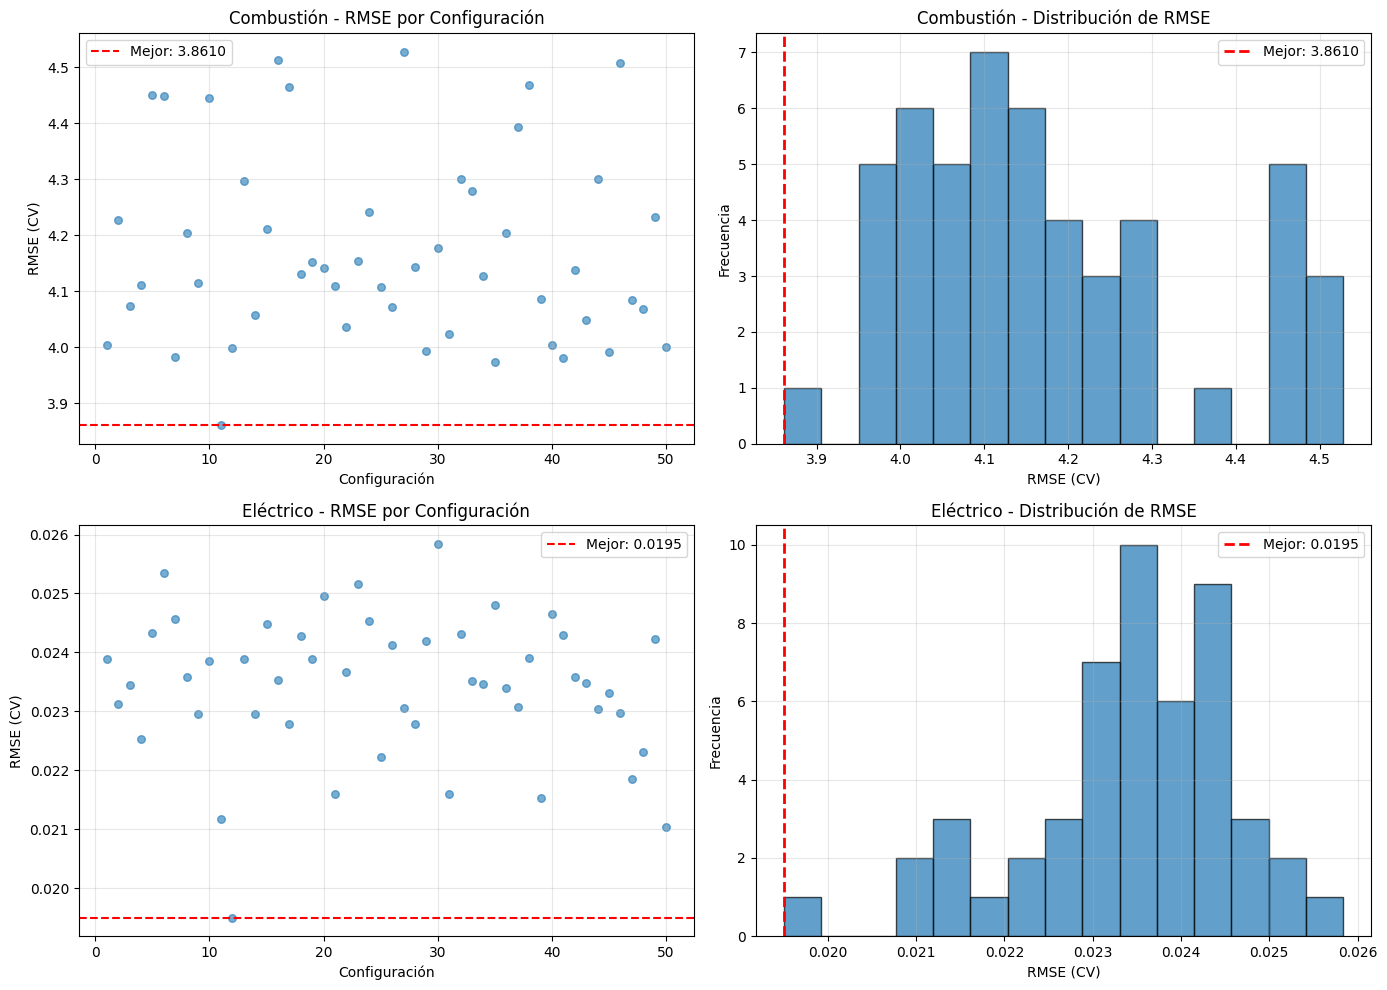

In [8]:
# Visualizar resultados de ambas búsquedas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (search, name) in enumerate([(random_search_combustion, 'Combustión'), 
                                        (random_search_electric, 'Eléctrico')]):
    cv_results = pd.DataFrame(search.cv_results_)
    scores = -cv_results['mean_test_score'].values
    
    # RMSE por configuración
    ax1 = axes[idx, 0]
    ax1.scatter(range(1, len(scores)+1), scores, alpha=0.6, s=30)
    ax1.axhline(y=-search.best_score_, color='r', linestyle='--', 
                label=f'Mejor: {-search.best_score_:.4f}')
    ax1.set_xlabel('Configuración')
    ax1.set_ylabel('RMSE (CV)')
    ax1.set_title(f'{name} - RMSE por Configuración')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Distribución de scores
    ax2 = axes[idx, 1]
    ax2.hist(scores, bins=15, edgecolor='black', alpha=0.7)
    ax2.axvline(x=-search.best_score_, color='r', linestyle='--', linewidth=2, 
                label=f'Mejor: {-search.best_score_:.4f}')
    ax2.set_xlabel('RMSE (CV)')
    ax2.set_ylabel('Frecuencia')
    ax2.set_title(f'{name} - Distribución de RMSE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Función para crear y entrenar modelo final
def train_final_model(X_dev_scaled, y_dev, best_params, target_name):
    print(f"\n{'='*60}")
    print(f"ENTRENAMIENTO FINAL: {target_name}")
    print(f"{'='*60}")
    
    # Configurar hiperparámetros finales
    final_params = best_params.copy()
    final_params['n_estimators'] = 1000
    final_params['early_stopping_rounds'] = 50
    
    print("Configuración del modelo final:")
    for param, value in final_params.items():
        if isinstance(value, float):
            print(f"  {param}: {value:.4f}")
        else:
            print(f"  {param}: {value}")
    
    # Crear modelo
    model = xgb.XGBRegressor(
        **final_params,
        objective='reg:squarederror',
        random_state=69,
        n_jobs=-1,
        verbosity=1
    )
    
    # Split para early stopping (90% train, 10% val)
    X_train, X_val, y_train, y_val = train_test_split(
        X_dev_scaled, y_dev, test_size=0.1, random_state=69
    )
    
    print(f"\nTrain: {len(X_train)} samples, Validation: {len(X_val)} samples")
    print("Entrenando...")
    
    start_time = time.time()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=50)
    elapsed_time = time.time() - start_time
    
    print(f"\n✓ Completado en {elapsed_time:.1f} segundos")
    print(f"  Iteraciones usadas: {model.best_iteration}")
    print(f"  Mejor RMSE (validation): {model.best_score:.6f}")
    
    return model

# ============================================================
# ENTRENAR MODELO FINAL - COMBUSTIÓN
# ============================================================
model_combustion = train_final_model(
    X_combustion_dev_scaled, y_combustion_dev, 
    random_search_combustion.best_params_, 
    "📊 Combustión (L/100km)"
)


ENTRENAMIENTO FINAL: Combustión (L/100km)
Configuración del modelo final:
  colsample_bytree: 0.7610
  gamma: 0.0333
  learning_rate: 0.0764
  max_depth: 5
  min_child_weight: 2
  n_estimators: 1000
  reg_alpha: 0.9970
  reg_lambda: 0.2843
  subsample: 0.9664
  early_stopping_rounds: 50

Train: 23408 samples, Validation: 2601 samples
Entrenando...
[0]	validation_0-rmse:4.90633

Train: 23408 samples, Validation: 2601 samples
Entrenando...
[0]	validation_0-rmse:4.90633
[50]	validation_0-rmse:3.59939
[50]	validation_0-rmse:3.59939
[100]	validation_0-rmse:3.43449
[100]	validation_0-rmse:3.43449
[150]	validation_0-rmse:3.34783
[150]	validation_0-rmse:3.34783
[200]	validation_0-rmse:3.27779
[200]	validation_0-rmse:3.27779
[250]	validation_0-rmse:3.22654
[250]	validation_0-rmse:3.22654
[300]	validation_0-rmse:3.19891
[300]	validation_0-rmse:3.19891
[350]	validation_0-rmse:3.17448
[350]	validation_0-rmse:3.17448
[400]	validation_0-rmse:3.15821
[400]	validation_0-rmse:3.15821
[450]	validation_

In [ ]:
# ============================================================
# ENTRENAR MODELO FINAL - ELÉCTRICO
# ============================================================
model_electric = train_final_model(
    X_electric_dev_scaled, y_electric_dev, 
    random_search_electric.best_params_, 
    "⚡ Eléctrico (kWh/km)"
)


ENTRENAMIENTO FINAL: Eléctrico (kWh/km)
Configuración del modelo final:
  colsample_bytree: 0.8866
  gamma: 0.0037
  learning_rate: 0.0796
  max_depth: 6
  min_child_weight: 6
  n_estimators: 1000
  reg_alpha: 0.1345
  reg_lambda: 1.7547
  subsample: 0.9333
  early_stopping_rounds: 50

Train: 23408 samples, Validation: 2601 samples
Entrenando...
[0]	validation_0-rmse:0.05055

Train: 23408 samples, Validation: 2601 samples
Entrenando...
[0]	validation_0-rmse:0.05055
[50]	validation_0-rmse:0.02010
[50]	validation_0-rmse:0.02010
[100]	validation_0-rmse:0.01975
[100]	validation_0-rmse:0.01975
[150]	validation_0-rmse:0.01981
[153]	validation_0-rmse:0.01981

✓ Completado en 0.3 segundos
  Iteraciones usadas: 103
  Mejor RMSE (validation): 0.019753
[150]	validation_0-rmse:0.01981
[153]	validation_0-rmse:0.01981

✓ Completado en 0.3 segundos
  Iteraciones usadas: 103
  Mejor RMSE (validation): 0.019753


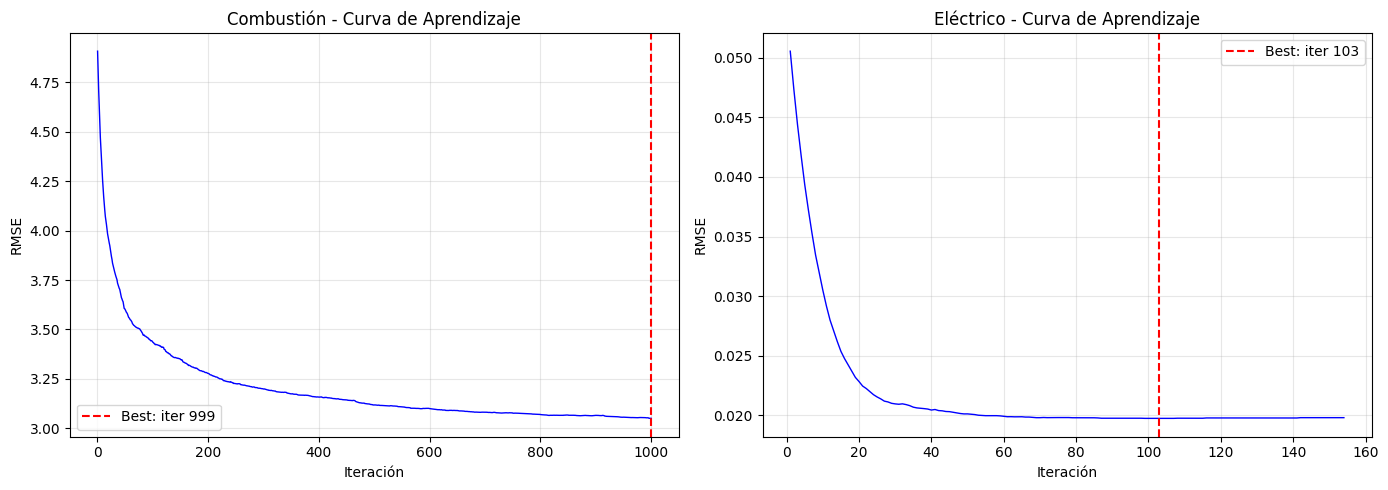

In [11]:
# Curvas de aprendizaje para ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, (model, name) in enumerate([(model_combustion, 'Combustión'), 
                                      (model_electric, 'Eléctrico')]):
    results = model.evals_result()
    if 'validation_0' in results:
        val_rmse = results['validation_0']['rmse']
        
        ax = axes[idx]
        ax.plot(range(1, len(val_rmse)+1), val_rmse, 'b-', linewidth=1)
        ax.axvline(x=model.best_iteration, color='r', linestyle='--', 
                   label=f'Best: iter {model.best_iteration}')
        ax.set_xlabel('Iteración')
        ax.set_ylabel('RMSE')
        ax.set_title(f'{name} - Curva de Aprendizaje')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# ============================================================
# PREPARAR TEST SETS Y EVALUAR
# Cada modelo se evalúa con su propio test set (datos apropiados)
# ============================================================

print(f"{'='*70}")
print("                    EVALUACIÓN FINAL EN TEST SET")
print(f"{'='*70}\n")

# --- PREPARAR TEST SET COMBUSTIÓN ---
X_combustion_test_scaled = scaler_combustion.transform(X_combustion_test)
X_combustion_test_scaled = pd.DataFrame(X_combustion_test_scaled, columns=sanitized_feature_cols, 
                                         index=X_combustion_test.index)

# --- PREPARAR TEST SET ELÉCTRICO ---
X_electric_test_scaled = scaler_electric.transform(X_electric_test)
X_electric_test_scaled = pd.DataFrame(X_electric_test_scaled, columns=sanitized_feature_cols, 
                                       index=X_electric_test.index)

# Función para calcular métricas
def calculate_metrics(y_true, y_pred, name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    # MAPE solo para valores no cero
    mask = y_true > 0.001  # Evitar división por valores muy pequeños
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / np.abs(y_true[mask]))) * 100
    else:
        mape = np.nan
    
    return {'name': name, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2, 'mape': mape}

# ============================================================
# PREDICCIONES Y MÉTRICAS - COMBUSTIÓN
# ============================================================
y_pred_combustion = model_combustion.predict(X_combustion_test_scaled)
metrics_combustion = calculate_metrics(y_combustion_test, y_pred_combustion, 'Combustión (L/100km)')

print("📊 MODELO COMBUSTIÓN (L/100km)")
print(f"   Test samples: {len(y_combustion_test)}")
print(f"   MSE:  {metrics_combustion['mse']:.6f}")
print(f"   RMSE: {metrics_combustion['rmse']:.4f}")
print(f"   MAE:  {metrics_combustion['mae']:.4f}")
print(f"   R²:   {metrics_combustion['r2']:.4f}")
print(f"   MAPE: {metrics_combustion['mape']:.2f}%")

# ============================================================
# PREDICCIONES Y MÉTRICAS - ELÉCTRICO
# ============================================================
y_pred_electric = model_electric.predict(X_electric_test_scaled)
metrics_electric = calculate_metrics(y_electric_test, y_pred_electric, 'Eléctrico (kWh/km)')

print(f"\n⚡ MODELO ELÉCTRICO (kWh/km)")
print(f"   Test samples: {len(y_electric_test)}")
print(f"   MSE:  {metrics_electric['mse']:.6f}")
print(f"   RMSE: {metrics_electric['rmse']:.4f}")
print(f"   MAE:  {metrics_electric['mae']:.4f}")
print(f"   R²:   {metrics_electric['r2']:.4f}")
if not np.isnan(metrics_electric['mape']):
    print(f"   MAPE: {metrics_electric['mape']:.2f}%")

# ============================================================
# COMPARACIÓN CV vs TEST
# ============================================================
cv_rmse_combustion = -random_search_combustion.best_score_
cv_rmse_electric = -random_search_electric.best_score_

print(f"\n{'='*70}")
print("COMPARACIÓN CV vs TEST (verificar que no hay overfitting):")
print(f"   📊 Combustión - CV RMSE: {cv_rmse_combustion:.4f}, Test RMSE: {metrics_combustion['rmse']:.4f}")
print(f"   ⚡ Eléctrico  - CV RMSE: {cv_rmse_electric:.4f}, Test RMSE: {metrics_electric['rmse']:.4f}")
print(f"{'='*70}")

Test set: 6503 samples

                    EVALUACIÓN FINAL EN TEST SET

MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)
  MSE:  9.691742
  RMSE: 3.113156
  MAE:  1.771202
  R²:   0.633049
  MAPE: 18.49%

MODELO 2: CONSUMO ELÉCTRICO (kWh/km)
  MSE:  0.000360
  RMSE: 0.018969
  MAE:  0.004824
  R²:   0.867523
  MAPE: 565.71%

COMPARACIÓN CV vs TEST:
  Combustión - CV RMSE: 3.8610, Test RMSE: 3.1132
  Eléctrico  - CV RMSE: 0.0195, Test RMSE: 0.0190


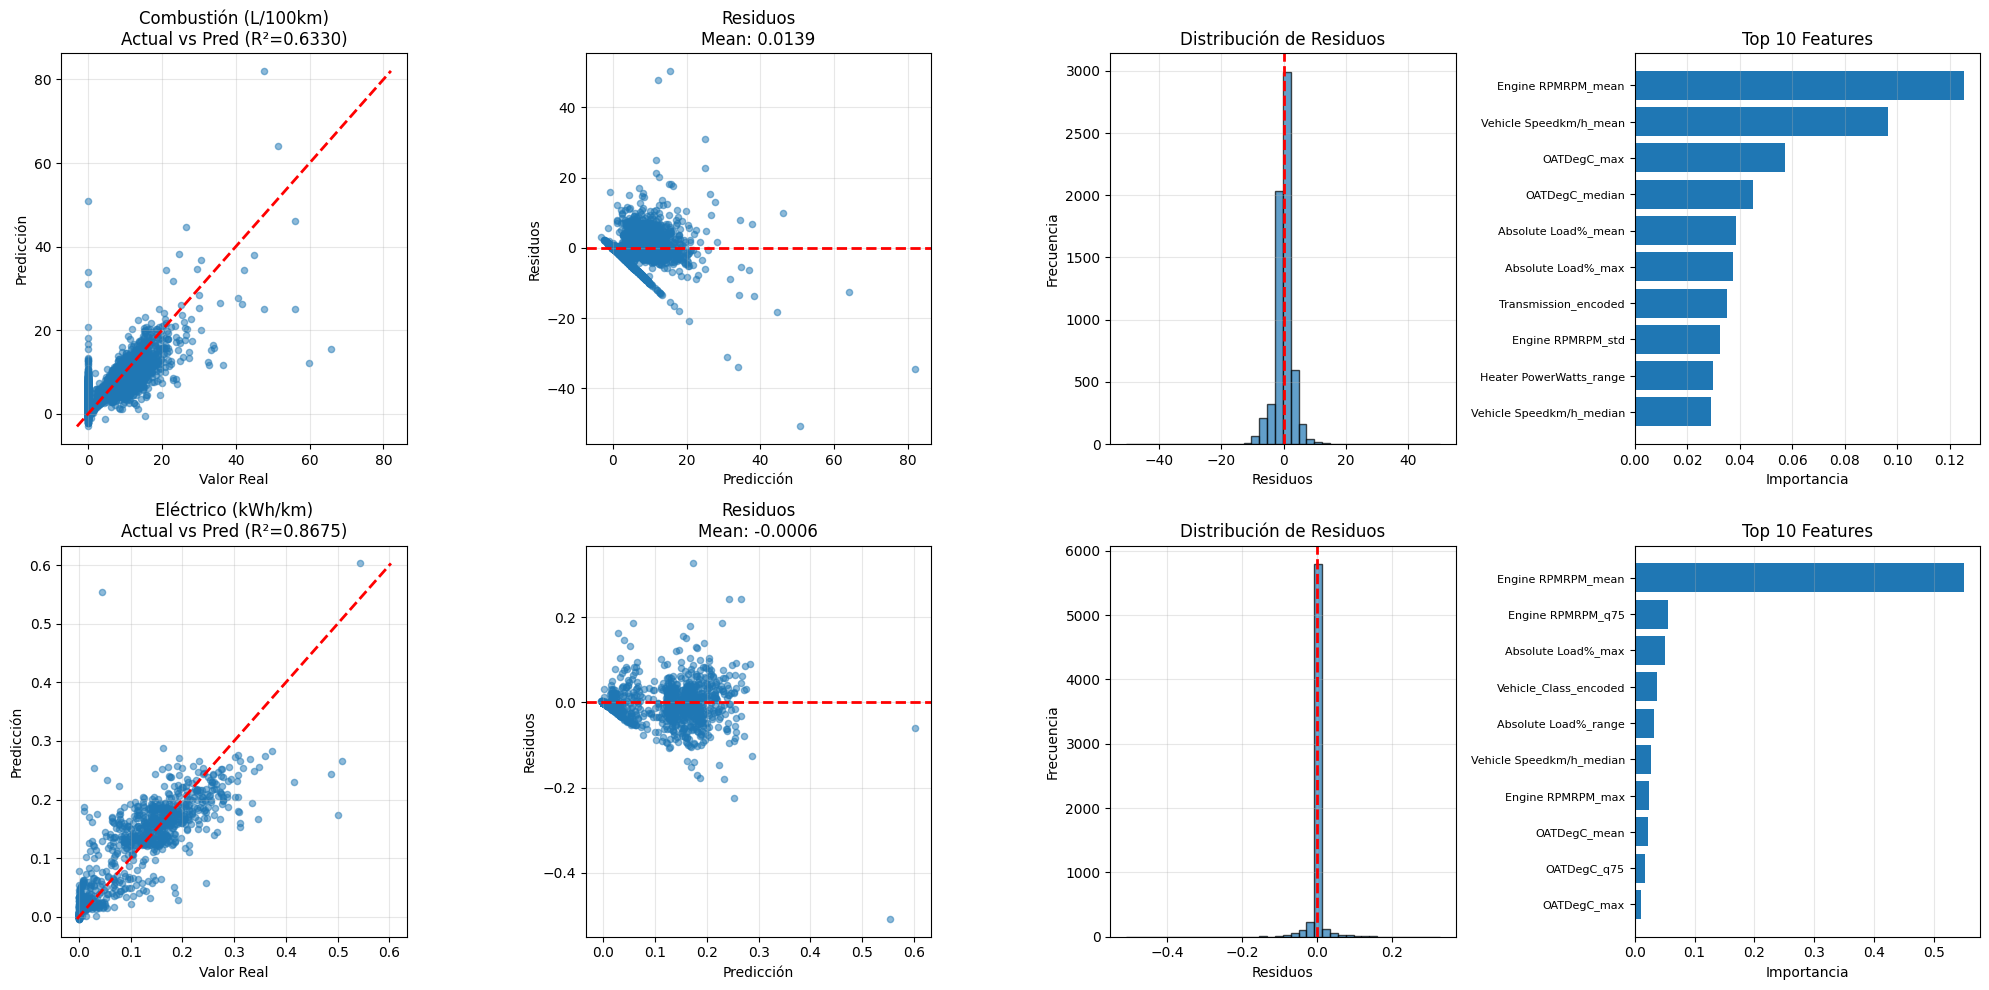


✓ Gráfico guardado en results\final_models_evaluation.png


In [13]:
# Visualización de resultados para ambos modelos
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for row, (y_true, y_pred, model, name) in enumerate([
    (y_combustion_test, y_pred_combustion, model_combustion, 'Combustión (L/100km)'),
    (y_electric_test, y_pred_electric, model_electric, 'Eléctrico (kWh/km)')
]):
    r2 = r2_score(y_true, y_pred)
    residuals = y_true - y_pred
    
    # 1. Actual vs Predicted
    ax1 = axes[row, 0]
    ax1.scatter(y_true, y_pred, alpha=0.5, s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax1.set_xlabel('Valor Real')
    ax1.set_ylabel('Predicción')
    ax1.set_title(f'{name}\nActual vs Pred (R²={r2:.4f})')
    ax1.grid(True, alpha=0.3)
    
    # 2. Residuos
    ax2 = axes[row, 1]
    ax2.scatter(y_pred, residuals, alpha=0.5, s=20)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicción')
    ax2.set_ylabel('Residuos')
    ax2.set_title(f'Residuos\nMean: {residuals.mean():.4f}')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribución de residuos
    ax3 = axes[row, 2]
    ax3.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='r', linestyle='--', lw=2)
    ax3.set_xlabel('Residuos')
    ax3.set_ylabel('Frecuencia')
    ax3.set_title('Distribución de Residuos')
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature Importance
    ax4 = axes[row, 3]
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    ax4.barh(range(10), importances[indices][::-1])
    ax4.set_yticks(range(10))
    ax4.set_yticklabels([sanitized_feature_cols[i] for i in indices][::-1], fontsize=8)
    ax4.set_xlabel('Importancia')
    ax4.set_title('Top 10 Features')
    ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'final_models_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Gráfico guardado en {RESULTS_DIR / 'final_models_evaluation.png'}")

In [14]:
# Comparación con baselines para ambos targets
print("="*70)
print("                COMPARACIÓN CON BASELINES")
print("="*70)

# Baselines para COMBUSTIÓN
mean_pred_comb = np.full(len(y_combustion_test), y_combustion_dev.mean())
median_pred_comb = np.full(len(y_combustion_test), np.median(y_combustion_dev))

baseline_comb = pd.DataFrame({
    'Model': ['XGBoost', 'Baseline (Mean)', 'Baseline (Median)'],
    'RMSE': [
        metrics_combustion['rmse'],
        np.sqrt(mean_squared_error(y_combustion_test, mean_pred_comb)),
        np.sqrt(mean_squared_error(y_combustion_test, median_pred_comb))
    ],
    'R2': [
        metrics_combustion['r2'],
        r2_score(y_combustion_test, mean_pred_comb),
        r2_score(y_combustion_test, median_pred_comb)
    ]
})

print("\nCOMBUSTIÓN (L/100km):")
display(baseline_comb)
rmse_improvement_comb = (baseline_comb.iloc[1]['RMSE'] - baseline_comb.iloc[0]['RMSE']) / baseline_comb.iloc[1]['RMSE'] * 100
print(f"  → Mejora sobre Mean Baseline: {rmse_improvement_comb:.1f}% en RMSE")

# Baselines para ELÉCTRICO
mean_pred_elec = np.full(len(y_electric_test), y_electric_dev.mean())
median_pred_elec = np.full(len(y_electric_test), np.median(y_electric_dev))

baseline_elec = pd.DataFrame({
    'Model': ['XGBoost', 'Baseline (Mean)', 'Baseline (Median)'],
    'RMSE': [
        metrics_electric['rmse'],
        np.sqrt(mean_squared_error(y_electric_test, mean_pred_elec)),
        np.sqrt(mean_squared_error(y_electric_test, median_pred_elec))
    ],
    'R2': [
        metrics_electric['r2'],
        r2_score(y_electric_test, mean_pred_elec),
        r2_score(y_electric_test, median_pred_elec)
    ]
})

print("\nELÉCTRICO (kWh/km):")
display(baseline_elec)
rmse_improvement_elec = (baseline_elec.iloc[1]['RMSE'] - baseline_elec.iloc[0]['RMSE']) / baseline_elec.iloc[1]['RMSE'] * 100
print(f"  → Mejora sobre Mean Baseline: {rmse_improvement_elec:.1f}% en RMSE")

                COMPARACIÓN CON BASELINES



COMBUSTIÓN (L/100km):


,Model,RMSE,R2
0,XGBoost,3.113156,0.633049
1,Baseline (Mean),5.139583,-0.000142
2,Baseline (Median),5.140082,-0.000336


  → Mejora sobre Mean Baseline: 39.4% en RMSE

ELÉCTRICO (kWh/km):


,Model,RMSE,R2
0,XGBoost,0.018969,0.867523
1,Baseline (Mean),0.052117,-0.000041
2,Baseline (Median),0.054497,-0.093428


  → Mejora sobre Mean Baseline: 63.6% en RMSE


## 6. Guardar Modelos Finales

In [15]:
# Guardar modelos finales y artefactos
final_model_dir = MODELS_DIR / 'final'
final_model_dir.mkdir(parents=True, exist_ok=True)

# Guardar modelo de COMBUSTIÓN
joblib.dump(model_combustion, final_model_dir / 'xgboost_combustion.pkl')
joblib.dump(random_search_combustion.best_params_, final_model_dir / 'best_params_combustion.pkl')
joblib.dump(scaler_combustion, final_model_dir / 'scaler_combustion.pkl')

# Guardar modelo de ELÉCTRICO
joblib.dump(model_electric, final_model_dir / 'xgboost_electric.pkl')
joblib.dump(random_search_electric.best_params_, final_model_dir / 'best_params_electric.pkl')
joblib.dump(scaler_electric, final_model_dir / 'scaler_electric.pkl')

# Guardar nombres de features
joblib.dump(sanitized_feature_cols, final_model_dir / 'feature_names.pkl')

# Guardar métricas finales
final_metrics = {
    'combustion': {
        **metrics_combustion,
        'cv_rmse': cv_rmse_combustion,
        'best_iteration': model_combustion.best_iteration,
        'n_train_samples': len(X_combustion_dev),
        'n_test_samples': len(X_combustion_test),
        'vehicle_types': ['ICE', 'HEV', 'PHEV']
    },
    'electric': {
        **metrics_electric,
        'cv_rmse': cv_rmse_electric,
        'best_iteration': model_electric.best_iteration,
        'n_train_samples': len(X_electric_dev),
        'n_test_samples': len(X_electric_test),
        'vehicle_types': ['PHEV', 'EV']
    },
    'n_features': len(sanitized_feature_cols),
}
joblib.dump(final_metrics, final_model_dir / 'final_metrics.pkl')

print("✓ Artefactos guardados:")
print(f"  📊 Modelo Combustión: {final_model_dir / 'xgboost_combustion.pkl'}")
print(f"     Scaler: {final_model_dir / 'scaler_combustion.pkl'}")
print(f"  ⚡ Modelo Eléctrico: {final_model_dir / 'xgboost_electric.pkl'}")
print(f"     Scaler: {final_model_dir / 'scaler_electric.pkl'}")
print(f"  📋 Features: {final_model_dir / 'feature_names.pkl'}")
print(f"  📊 Métricas: {final_model_dir / 'final_metrics.pkl'}")

✓ Artefactos guardados:
  - Modelo Combustión: models\saved_models\final\xgboost_combustion.pkl
  - Modelo Eléctrico: models\saved_models\final\xgboost_electric.pkl
  - Scaler: models\saved_models\final\scaler_final.pkl
  - Features: models\saved_models\final\feature_names.pkl
  - Métricas: models\saved_models\final\final_metrics.pkl


## 7. Resumen Final

In [ ]:
print("="*70)
print("                    RESUMEN DEL PROYECTO")
print("="*70)
print()
print("MODELOS FINALES: XGBoost Regressor (x2 - Modelos Separados)")
print()
print("ARQUITECTURA:")
print("  - Modelo 1: Predice consumo de combustión para ICE, HEV, PHEV")
print("  - Modelo 2: Predice consumo eléctrico para PHEV, EV")
print("  - Cada modelo tiene su propio scaler y se entrena solo con datos relevantes")
print()

print("="*70)
print("📊 MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)")
print("="*70)
print(f"\nDatos:")
print(f"  - Tipos de vehículo: ICE, HEV, PHEV")
print(f"  - Dev samples: {len(X_combustion_dev)}")
print(f"  - Test samples: {len(X_combustion_test)}")
print(f"  - Features: {len(sanitized_feature_cols)}")
print("\nHiperparámetros óptimos:")
for param, value in random_search_combustion.best_params_.items():
    if isinstance(value, float):
        print(f"  - {param}: {value:.4f}")
    else:
        print(f"  - {param}: {value}")
print(f"\nMétricas (Test Set):")
print(f"  - RMSE: {metrics_combustion['rmse']:.4f} L/100km")
print(f"  - MAE:  {metrics_combustion['mae']:.4f} L/100km")
print(f"  - R²:   {metrics_combustion['r2']:.4f}")
print(f"\nVerificación Overfitting:")
print(f"  - CV RMSE: {cv_rmse_combustion:.4f}")
print(f"  - Test RMSE: {metrics_combustion['rmse']:.4f}")
diff_comb = abs(cv_rmse_combustion - metrics_combustion['rmse'])/cv_rmse_combustion
print(f"  - Diferencia: {diff_comb*100:.1f}%", end="")
print(" ✓ OK" if diff_comb < 0.15 else " ⚠ Posible overfitting")

print()
print("="*70)
print("⚡ MODELO 2: CONSUMO ELÉCTRICO (kWh/km)")
print("="*70)
print(f"\nDatos:")
print(f"  - Tipos de vehículo: PHEV, EV")
print(f"  - Dev samples: {len(X_electric_dev)}")
print(f"  - Test samples: {len(X_electric_test)}")
print(f"  - Features: {len(sanitized_feature_cols)}")
print("\nHiperparámetros óptimos:")
for param, value in random_search_electric.best_params_.items():
    if isinstance(value, float):
        print(f"  - {param}: {value:.4f}")
    else:
        print(f"  - {param}: {value}")
print(f"\nMétricas (Test Set):")
print(f"  - RMSE: {metrics_electric['rmse']:.4f} kWh/km")
print(f"  - MAE:  {metrics_electric['mae']:.4f} kWh/km")
print(f"  - R²:   {metrics_electric['r2']:.4f}")
print(f"\nVerificación Overfitting:")
print(f"  - CV RMSE: {cv_rmse_electric:.4f}")
print(f"  - Test RMSE: {metrics_electric['rmse']:.4f}")
diff_elec = abs(cv_rmse_electric - metrics_electric['rmse'])/cv_rmse_electric
print(f"  - Diferencia: {diff_elec*100:.1f}%", end="")
print(" ✓ OK" if diff_elec < 0.15 else " ⚠ Posible overfitting")

print()
print("="*70)
print("           ✅ MODELOS ENTRENADOS CORRECTAMENTE")
print("="*70)
print()
print("NOTAS:")
print("  - No hay data leakage: columnas de cálculo de Y excluidas de X")
print("  - No hay contaminación: cada modelo usa solo datos aplicables")
print("  - Test set separado: evaluación honesta sin sesgos")
print("  - Scalers separados: cada modelo tiene su propio scaler")
print("="*70)

                    RESUMEN DEL PROYECTO

MODELOS FINALES: XGBoost Regressor (x2)

DATOS:
  - Dataset: Metrics (estadísticas agregadas por viaje)
  - Features: 58
  - Samples totales: 32512
  - Dev set: 26009 samples (80%)
  - Test set: 6503 samples (20%)

MODELO 1: CONSUMO DE COMBUSTIÓN (L/100km)

Hiperparámetros óptimos:
  - colsample_bytree: 0.7610
  - gamma: 0.0333
  - learning_rate: 0.0764
  - max_depth: 5
  - min_child_weight: 2
  - n_estimators: 487
  - reg_alpha: 0.9970
  - reg_lambda: 0.2843
  - subsample: 0.9664

Métricas (Test Set):
  - RMSE: 3.1132
  - MAE:  1.7712
  - R²:   0.6330

Verosimilitud:
  - CV RMSE: 3.8610
  - Test RMSE: 3.1132
  - Diferencia: 19.4% ⚠

MODELO 2: CONSUMO ELÉCTRICO (kWh/km)

Hiperparámetros óptimos:
  - colsample_bytree: 0.8866
  - gamma: 0.0037
  - learning_rate: 0.0796
  - max_depth: 6
  - min_child_weight: 6
  - n_estimators: 380
  - reg_alpha: 0.1345
  - reg_lambda: 1.7547
  - subsample: 0.9333

Métricas (Test Set):
  - RMSE: 0.0190
  - MAE:  0